<a href="https://colab.research.google.com/github/lauvshree/pneumonia-detection/blob/master/YOLOv3_RSNA_Starting_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Initital set up for building the model

In [0]:
import math
import os
import shutil
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import cv2
from sklearn.model_selection import train_test_split


In [0]:
random_stat = 123
np.random.seed(random_stat)

In [0]:
%tensorflow_version 2.x
import tensorflow
print(tensorflow.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
from google.colab import drive
drive.mount('/content/gdrive/',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


## 2. Data Migration for YOLOv3

### 2.0. Make subdirectories

In [0]:
project_path = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/"
data_path = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/"
images_path = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/training_images/"


img_dir = data_path+ "training_images"  # .jpg
label_dir = data_path+ "training_labels"  # .txt
metadata_dir = data_path+ "cfg" # .txt

cfg_dir = data_path + "cfg"
#To save the model checkpoints
backup_dir = data_path + "backup"


# We are using the image dir we generated in the EDA. The other directories will have to be created if they don't exist
for directory in [label_dir, metadata_dir, cfg_dir, backup_dir]:
    if os.path.isdir(directory):
        continue
    os.mkdir(directory)

### 2.1. Load patient_data.csv

In [0]:
#The CSV has generated as a part of the EDA has details of the bounding boxes as may be applicable. 
patient_data = pd.read_csv(os.path.join(data_path, "patients_data.csv"))
patient_data.head()

,Unnamed: 0,patientId,x,y,width,height,Target,Image,Modality,PatientAge,PatientSex,BodyPartExamined,ViewPosition,ConversionType,Rows,Columns,PixelSpacing
0,0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,/content/gdrive/My Drive/Colab Notebooks/Capst...,CR,19.0,M,CHEST,AP,WSD,1024.0,1024.0,0.168
3,3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,/content/gdrive/My Drive/Colab Notebooks/Capst...,CR,28.0,M,CHEST,PA,WSD,1024.0,1024.0,0.143
4,4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,/content/gdrive/My Drive/Colab Notebooks/Capst...,CR,32.0,F,CHEST,AP,WSD,1024.0,1024.0,0.139


### 2.2. Generate image details for training YOLO
* YOLO needs .txt file for each image, which contains bounding boxes in the image that looks like:
```
<object-class_1> <x_1> <y_1> <width_1> <height_1>
<object-class_2> <x_2> <y_2> <width_2> <height_2>
```
* <object-class\>: Since RSNA task is binary classification basically, <object-class\> is 1 as we are going to train on the images with Pneumonia.
* <x\>, <y\>: Those are float values of bbox center coordinate, divided by image width and height respectively.
* <w\>, <h\>: Those are width and height of bbox, divided by image width and height respectively.


In [0]:

def save_yolo_input_txt():
    # rsna defualt image size
    img_size = 1024
    pneumonia_patients = patient_data[patient_data.Target == 1]
    for index,row in pneumonia_patients.iterrows():
      label_fp = os.path.join(label_dir, "{}.txt".format(row['patientId']))
      f = open(label_fp, "a")
      top_left_x = row['x']
      top_left_y = row['y']
      w = row['width']
      h = row['height']
      
      rx = top_left_x/img_size
      ry = top_left_y/img_size
      rw = w/img_size
      rh = h/img_size
      rcx = rx+rw/2
      rcy = ry+rh/2
      
      line = "{} {} {} {} {}\n".format(0, rcx, rcy, rw, rh)
      
      f.write(line)
      f.flush()
      f.close()


In [0]:
#Uncomment this line to generate the YOLO input. This need not be done everytime you run the notebook.
# save_yolo_input_txt()

### 2.3. Plot a sample train image and label

In [0]:
#Take a patiend id where target is 1 and show it with the bounding boxes

ex_patient_id = patient_data[patient_data.Target == 1].sample(1)
for index,row in ex_patient_id.iterrows():
  ex_patient_id = row['patientId']
print(ex_patient_id)
ex_img_path = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/training_images/"+ex_patient_id+".jpg"
ex_label_path = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/training_labels/"+ex_patient_id+".txt"



In [0]:
img_size = 1014
print(ex_img_path)
plt.imshow(cv2.imread(ex_img_path))

with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

#Git Clone the Darknet YOLO model

In [0]:
#For the following command to be run, you must have cloned darknet from git repo and run a make. 

darknet_dir = '/content/gdrive/My Drive/Colab Notebooks/Capstone Project/darknet'
os.chdir("/content/gdrive/My Drive/Colab Notebooks/Capstone Project/")
if os.path.exists(darknet_dir) == False :
  !git clone https://github.com/pjreddie/darknet
  os.chdir(darknet_dir)
else:
  os.chdir(darknet_dir)
  !git pull



Already up to date.


In [0]:
#The darknet directory has to run `make -B` (-B option runs make even if the directory has already run it once) everytime the kernel restarts
os.chdir(darknet_dir)
!make -B


mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/image.c -o obj/image.o
gcc 

### 2.4. Generate train/val file path list (.txt)
* We should give the list of image paths to YOLO. two seperate list textfiles for training images and validation images.

In [0]:
def write_train_list(metadata_dir, img_dir, name, series):
    list_fp = os.path.join(metadata_dir, name)
    with open(list_fp, "w") as f:
        for patient_img in series:
            line = "{}\n".format(os.path.join(img_dir, patient_img))
            f.write(line)

In [0]:
patient_data_unique = patient_data[patient_data.Target == 1].patientId.drop_duplicates()

patient_xray_images = patient_data_unique+".jpg"

tr_series, val_series = train_test_split(patient_xray_images, test_size=0.1, random_state=random_stat)
print("The # of train set: {}, The # of validation set: {}".format(tr_series.shape[0], val_series.shape[0]))
# train image path list
write_train_list(metadata_dir, img_dir, "tr_list.txt", tr_series)
# validation image path list
write_train_list(metadata_dir, img_dir, "val_list.txt", val_series)

## 3. Prepare Configuration Files for Using YOLOv3
We should prepare and modify config files, and bring pre-trained weights necessary for training. Darknet need ths following files to train the model
```
 cfg/rsna.data #Has the location of all the input files and output directories
 cfg/rsna.names #Has the number of different names that need to be identified
 darknet53.conv.74 #The weights from darknet 
 cfg/rsna_yolov3.cfg_train #The config file which needs to be tuned to match our dataset
```

### - cfg/rsna.data
This file point to RSNA data path
  * train: Path to training image list textfile
  * valid: Path to validation image list textfile
  * names: The file containing the possible RSNA names - This in our case is a file named rsna.names in the same directory, containing just one entry 'pneumonia' as that is the only class. 
  * backup: A directory where trained weights(checkpoints) will be stored as training progresses.
  * results: Path to the directory where the prediction results are to be stored.

Sample content of rsna.names
```
classes= 1
train  = tr_list.txt
valid  = val_list.txt
names  = rsna.names
eval  = rsna.names
backup = model_backup
results = pred_results
```

In [0]:
os.chdir(cfg_dir)

### - darknet53.conv.74  (Download Pre-trained Model)
For training, we would download the pre-trained model weights(darknet53.conv.74) using following wget command. Alternatively, you can download it from the link used in wget command below and upload it to the relevant directory in your path. 

In [0]:
if os.path.exists(cfg_dir+"darknet53.conv.74") == False:
  !wget -q https://pjreddie.com/media/files/darknet53.conv.74

Make changes to the cfg file in ${darknet_dir}/cfg to suit it to RSNA dataset and store it as rsna_yolov3_batch64.cfg_train to be used in training the model.

In [0]:
if os.path.exists(cfg_dir+"rsna_yolov3_batch64.cfg_train") == False:
  !wget --no-check-certificate -q "https://docs.google.com/uc?export=download&id=18ptTK4Vbeokqpux8Onr0OmwUP9ipmcYO" -O rsna_yolov3_batch64.cfg_train

## 4. Training YOLOv3



### 4.0. Command for training with Pre-trained CNN Weights (darknet53.conv.74)


In [0]:
os.chdir("/content/gdrive/My Drive/Colab Notebooks/Capstone Project/darknet")
!./darknet detector train /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone\ Project/data/cfg/rsna.data /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone\ Project/data/cfg/rsna_yolov3.cfg_train /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone\ Project/data/cfg/darknet53.conv.74

The model backup is stored in ${darknet_dir}/model_backup. We could get until 6238 iterations and then google colab timed out, after 5 hours. It is very resource consuming. We made use of the model weights trained on the same dataset for 15300 iterations from this link [https://docs.google.com/uc?export=download&id=1FDzMN-kGVYCvBeDKwemAazldSVkAEFyd].

## 5. How to use trainined YOLOv3 for test images (command line)

### 5.0. Copy sample test image

In [0]:
ex_patient_id = patient_data[patient_data.Target == 1].patientId.values[2]
ex_img_path = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/training_images/"+ex_patient_id+".jpg"
shutil.copy(ex_img_path, "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/test.jpg")


'/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/test.jpg'

### 5.1. Create test cfg file 
The cfg file `batch` and `subdivision` is set 1 each. The width and height of images set to 608 and save it as rsna_yolov3.cfg_test.


### Test the model on the validation data

In [0]:
os.chdir("/content/gdrive/My Drive/Colab Notebooks/Capstone Project/darknet")
!./darknet detector valid /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone\ Project/data/cfg/rsna.data /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone\ Project/data/cfg/rsna_yolov3.cfg_test /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone\ Project/data/cfg/rsna_yolov3_15300.weights

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

In [0]:
ex_model_path = "./pred_results/comp4_det_test_pneumonia.txt"

df = pd.read_table(ex_model_path,sep=" ",names=['imgName','scale','x','y','w','h'])
df.sample(1)

for index,row in df.sample(1).iterrows():
  imgName = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/training_images/"+row['imgName']+".jpg"
  plt.imshow(cv2.imread(imgName))
  x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size


In [0]:
os.chdir("/content/gdrive/My Drive/Colab Notebooks/Capstone Project/darknet")
!./darknet detector test /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone\ Project/data/cfg/rsna.data /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone\ Project/data/cfg/rsna_yolov3.cfg_test /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone\ Project/data/cfg/rsna_yolov3_15300.weights /content/gdrive/My\ Drive/Colab\ Notebooks/Capstone\ Project/data/test.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

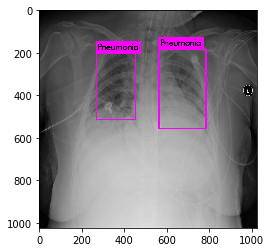

In [0]:
plt.imshow(cv2.imread("predictions.jpg"))

/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/training_images/00436515-870c-4b36-a041-de91049b9ab4.jpg
0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.673828125 0.36962890625 0.25 0.4423828125

0 0.36181640625 0.33349609375 0.2080078125 0.3701171875



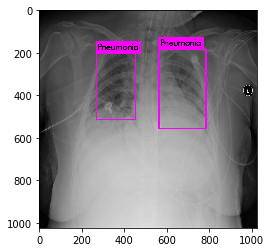

In [0]:
ex_img_path = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/training_images/"+ex_patient_id+".jpg"
ex_label_path = "/content/gdrive/My Drive/Colab Notebooks/Capstone Project/data/training_labels/"+ex_patient_id+".txt"

img_size = 1014
print(ex_img_path)
plt.imshow(cv2.imread("predictions.jpg"))
with open(ex_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rcx, rcy, rw, rh = list(map(float, line.strip().split()))
        x = (rcx-rw/2)*img_size
        y = (rcy-rh/2)*img_size
        w = rw*img_size
        h = rh*img_size
        #Uncomment this line to see the overlap of actual and predicted outcome
        # plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])